In [10]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from tabulate import tabulate as tb
import pandas as pd
from scipy import stats

## Lab #3: Asking a statistical question
This week we are going to concentrate on asking a statistical question. This process always consists of two steps:

1. Writing down in words very precisely what question you are trying to ask.
2. Converting the precise english question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and the to integral to do to obtain a probability.

So in this lab we will assume that we know the form of the signal-free background distribution (determining a distribution from data will be next week's lab). In each of our three examples, your task will be to state the statistical question, convert it to math, then perform the associated analyses.

## Problem 1
In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

To make this a bit concrete, we will simulate a little data. Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

#### A) So our goal is to identify bad data and throw it out.

1. Start by exploring the data you have created with appropriate plots
2. State the statistical question in words. Be very clear, and describe why you have chosen this statistical question.
3. Restate your question in math. Be very clear.
4. Apply your statistical test and construct a truth table.

The idea is how often you kept the known good data (True Pos), how often you correctly discarded bad data (False Neg), and how often mistakes were made of either omission or commission (True Neg, & False Pos).

In [11]:
#creating a gaussian distributed data set with bad data points mixed in
good_data = stats.norm.rvs(size=100000, loc=12, scale=0.4) 
bad_data  = [10.0,10.3,2.1,0.0,0.0,15.6,22.3,12.7]         
data = np.append(good_data, bad_data)
x = np.linspace(0,100000,100008)

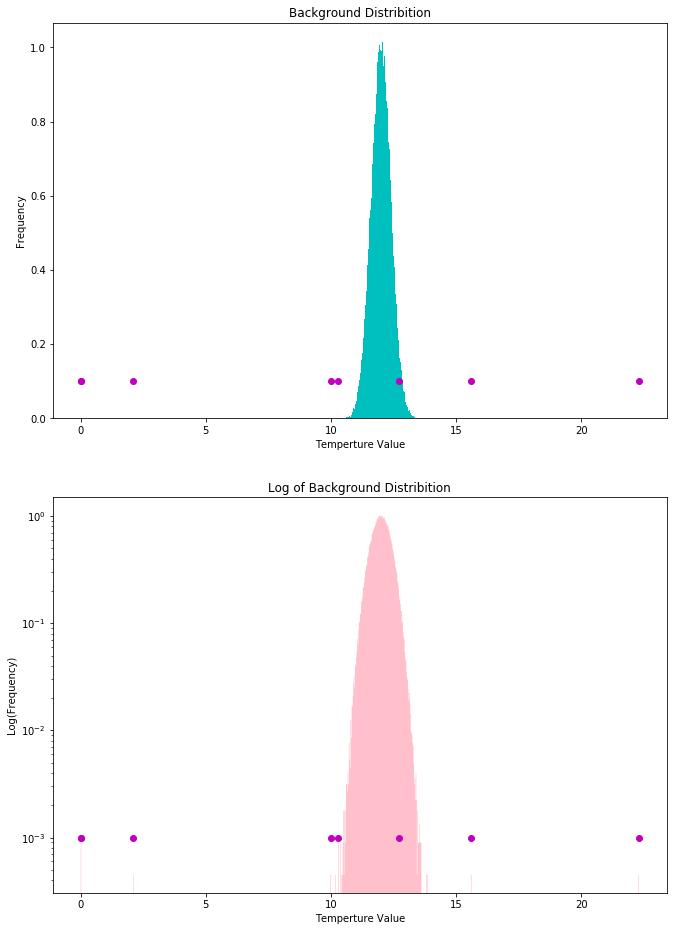

In [12]:
#plotting the background distribution linearly and logarithmically
fig,ax = plt.subplots(2,1)                    
fig.set_size_inches(11,16) 

for point in bad_data:
    ax[0].plot(point,0.1, 'mo')
    ax[1].plot(point,0.001, 'mo')

ax[0].set_title("Background Distribition")
ax[0].set_xlabel("Temperture Value")
ax[0].set_ylabel('Frequency')
ax[0].hist(data, bins=1001, density=True, color='c');

ax[1].set_title("Log of Background Distribition")
ax[1].set_xlabel("Temperture Value")
ax[1].set_ylabel('Log(Frequency)')
ax[1].set_yscale('log')
ax[1].hist(data, bins=1001, density=True, color="pink", histtype='stepfilled');

I plotted the distribution linearly (first graph) to show the gaussian shape that is expected of the background distribution. This graph does not show the bad data points that well, so I also plotted the distribution with a logarithmic y-axis to better show what is happening at the tails of the distribution. Additionally, I plotted purple dots where the bad data lives. The height of the dots don't have any significance, they are there simply as a visual aid.

**Statistical Question:** Assuming we know there is 8 data points that are not a part of our background distribution, what data points are greater than 3.77 sigma and thus a product of a misbehaving temperture control?

**Explanation:** I chose this question because I wish to throw out as much bad data as I can while simulatinously keeping the good data. There is an 8 / 100,008 probability of finding a bad point. This corresponds to a 3.77 sigma on a standard normal distribution (math/code done in the box below). 


**Note:** If we could not assume we knew the bad data points beforehand, we would not be able to determine an exact inital sigma. Instead, this is how I would determine the starting point. The 68-95-99.7 rule for gaussian distribution states that 68% of the data lives within one sigma of the mean, 95% within two sigma, and 99.7% within 3 sigma. So, the likelihood of a data point being a part of our background distribution for temperature decreases with a higher sigma. Thus, data points higher than 5 sigma are likely to be the bad data points we wish to discard (4 sigma may include some good data points and I don't want to throw those out).
 
  
**Math:** To differeniate points above 3.77 sigma, I just need to make a simple comparison:  
    $ Point > (mean - (\sigma)(std))$ and $ Point < (mean + (\sigma)(std))$  
    If both these statements are true for the given data point, then that data point lives within 3.77 sigma and thus will be considered a good data point.

In [13]:
probability = 8 / 100008
sigma = stats.norm.isf(probability)  #Taking an integral of the probability to find a sigma on a standard normal distribution
print("Sigma:", sigma)
x = stats.norm.isf(probability, loc=12, scale=0.4) #taking an integral of the probability for our 
                                                   #specific distribution to find x poisition
x1 = 12 + 3.77 * 0.4                               #x = mean + sigma * std
print("Comparing x-values through different methods:",x,"versus",x1)

Sigma: 3.7750318807261567
Comparing x-values through different methods: 13.510012752290463 versus 13.508


In [14]:
mean = 12     # mean of the background distribution
std  = 0.4    # standard deviation of the background distribution
sigma= 3.77   # sigma threshold for data-points to surpass to be considered bad

reported_good = [] # An array to keep all the reported good points
reported_bad = []  # An array to keep all the reported bad points
false_pos = 0      # A bad data point counted as a good one
false_neg = 0      # A bad data point counted as a bad one
true_pos = 0       # A good data point counted as a good data point
true_neg = 0       # A good data point counted as a bad data point


def not_out(value, x):
    return value > (mean - x*std) and value < (mean + x*std)


for point in data:
    if not_out(point, sigma):
        reported_good.append(point)
        if bad_data.count(point) > 0:
            false_pos+=1
        else: 
            true_pos+=1
        
    else:
        reported_bad.append(point)
        if bad_data.count(point) > 0:
            false_neg+=1
        else:
            true_neg+=1

print(tb([["Positive", true_pos,false_pos], ["Negative",true_neg,false_neg]], headers=["True", "False"]))

            True    False
--------  ------  -------
Positive   99979        1
Negative      21        7


For reference, this is how to interpret the truth tables in this problem.  
True Positive: A good data point (true) counted as a good data point (positive)    
True Negative: A good data point (true) counted as a bad  data point (negative)    
False Positive: A bad data point (false) counted as a good data point (positive)  
False Negative: A bad data point (false) counted as a bad  data point (negative)  

According to the truth table, 99985 good data points were counted as good while 15 were counted as bad, and thus chucked. On the other hand, only one of the bad data points managed to slip into the good data. This one is probably the bad data point close to the mean, 12.7, which would be impossible to remove without also removing most of the background distribution. Overall, 3.77 sigma was a decent choice for a cut off because almost all of the bad points were excluded while the background distribtuion wasn't impacted too much.

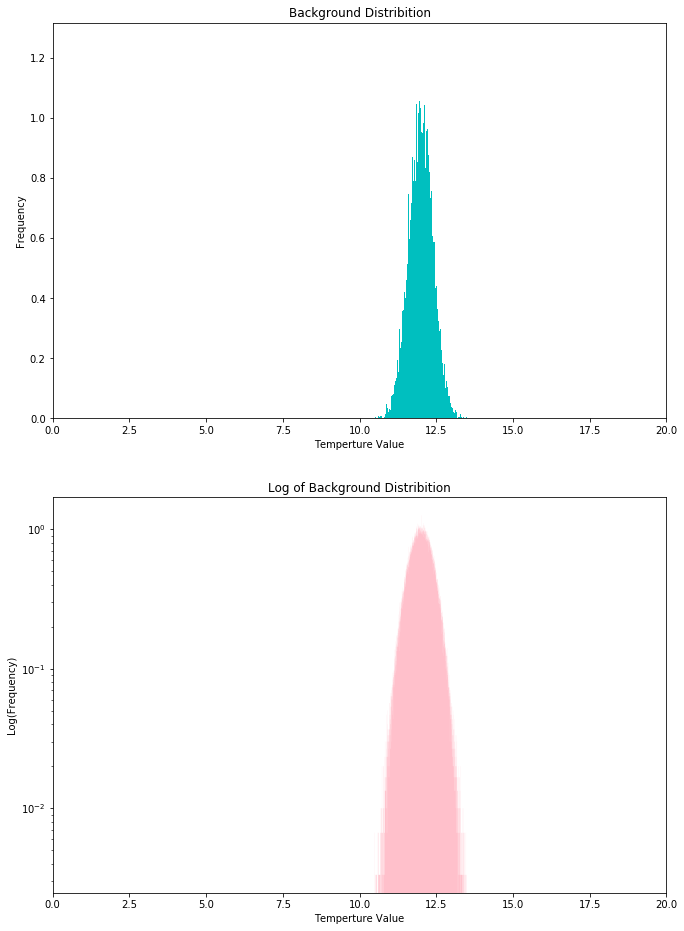

In [15]:
fig,ax = plt.subplots(2,1)                    
fig.set_size_inches(11,16) 


ax[0].set_title("Background Distribition")
ax[0].set_xlabel("Temperture Value")
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0,20)
ax[0].hist(reported_good, bins=1001, density=True, color='c');

ax[1].set_title("Log of Background Distribition")
ax[1].set_xlabel("Temperture Value")
ax[1].set_ylabel('Log(Frequency)')
ax[1].set_yscale('log')
ax[1].set_xlim(0,20)
ax[1].hist(reported_good, bins=1001, density=True, color="pink", histtype='stepfilled');

Reploting the distribution after excluding data points futher than 3.77 standard deviations shows that linearly there isn't much change. The overall shape is still a skinny gaussian as expected. The qualitative differences really show in the logarithmic graph. No longer do we see any spikes of bad data points past the tails, and the tails themselves appear to be smoother than before due to a small portion of the actual background distribution being thrown out.

#### B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?

The further away from the mean the x-value (the point beyond which we exclude data) is, the more omissions will occur. We can predict this quantity by taking an integral of the standard normal distribution from infinity to our threshold sigma to find a probability. Multiplying this probability by 100,000 will give us the number of good data points we have excluded. 

#### C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

The closer a bad data point is to the mean, the easier it is for the bad data point to sneak in. These, unfortunately, cannot be accounted for without significantly impacting the background distribution. For bad data points such as 12.7, our threshold would have to be rather small, a sigma of 1.75 ((12.7 - 12)/0.4). Using this threshold (code below), we are able to exclude all bad data points, but we also throw out 7,983 good data points. This may not seem like much compared to 100,000 until we look at the tails of our new distribution. We see in both plots below, that the tails have been chopped off. In other distributions, this could be quite problematic for determining the signifance of a discovery. So overall, it is better to let that one bad point in than chopping off the tails of the distribution.

In [16]:
mean = 12     # mean of the background distribution
std  = 0.4    # standard deviation of the background distribution
sigma= 1.75   # sigma threshold for data-points to surpass to be considered bad

reported_good = [] # An array to keep all the reported good points
reported_bad = []  # An array to keep all the reported bad points
false_pos = 0      # A bad data point counted as a good one
false_neg = 0      # A bad data point counted as a bad one
true_pos = 0       # A good data point counted as a good data point
true_neg = 0       # A good data point counted as a bad data point


def not_out(value, x):
    return value > (mean - x*std) and value < (mean + x*std)


for point in data:
    if not_out(point, sigma):
        reported_good.append(point)
        if bad_data.count(point) > 0:
            false_pos+=1
        else: 
            true_pos+=1
        
    else:
        reported_bad.append(point)
        if bad_data.count(point) > 0:
            false_neg+=1
        else:
            true_neg+=1

print(tb([["Positive", true_pos,false_pos], ["Negative",true_neg,false_neg]], headers=["True", "False"]))

            True    False
--------  ------  -------
Positive   91982        0
Negative    8018        8


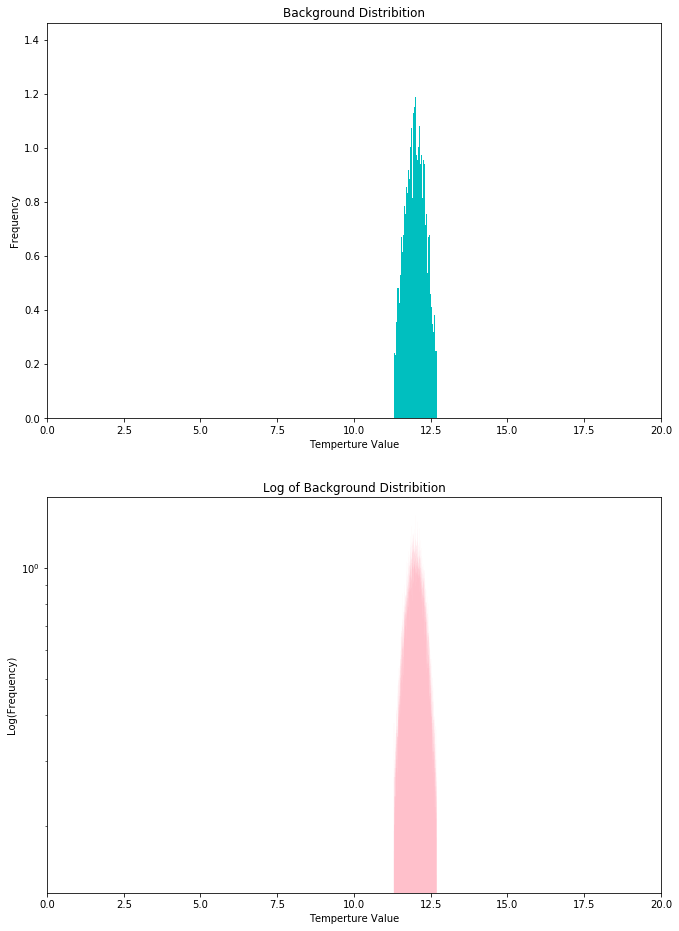

In [17]:
fig,ax = plt.subplots(2,1)                    
fig.set_size_inches(11,16) 


ax[0].set_title("Background Distribition")
ax[0].set_xlabel("Temperture Value")
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0,20)
ax[0].hist(reported_good, bins=1001, density=True, color='c');

ax[1].set_title("Log of Background Distribition")
ax[1].set_xlabel("Temperture Value")
ax[1].set_ylabel('Log(Frequency)')
ax[1].set_yscale('log')
ax[1].set_xlim(0,20)
ax[1].hist(reported_good, bins=1001, density=True, color="pink", histtype='stepfilled');

## Problem 2
In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

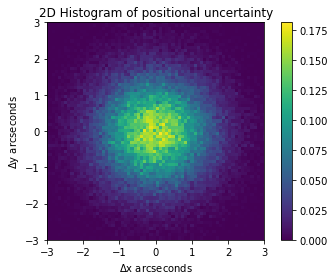

In [18]:
#a = np.concatenate(np.array(stats.norm.rvs( scale = 1, size = 100000)), np.array(stats.norm.rvs( scale = 1, size = 100000)), axis = 1)
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty")
plt.ylabel("$\Delta$y arcseconds")
plt.xlabel("$\Delta$x arcseconds")
plt.colorbar(h[3], ax=ax)

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

1. What is the question in words?
2. What is the question in math?
[Hint: Come up with an analytic description of your pdf(). The Blue Book may be helpful here.]

**Statistical Question:** Ignoring proper motion, a star's movement on the sky is due to atmospheric effects and produces a 2D background distribution. The displacement of an astroid against this distribution would be $\sqrt{(\Delta x)^2 + (\Delta y)^2} $. What displacement in arcseconds from the mean of the 2D Gaussian distribution of a star does an astroid have to move for us to conclude a 5-sigma detection?  

**Math:** In this problem we have a two-dimensional vecter given by d = (x,y), which represents position. the distibution in both x and y directions is given by a standard normal distribution, $ p_x(u,\sigma)= p_y(u,\sigma)= \frac{e^{-u^2/(2\sigma^2)}}{\sqrt{2\pi\sigma^2}}$. The cumulative distribution of this is the integral of the distributions in x and y multiplied by each other over a disc with a radius of the displacement. The derivative of this with respect to u, gives us the probability density of the displacement, which turns out to be a rayleigh distribution: $p_d = \frac{xe^{-x^2/(2\sigma^2)}}{\sigma^2}$. Now that we have the distribution we need, we can find the displacement of a 5-sigma detection by taking the integral of the cdf until we reach a probability of 1/3500000. This will spit out the displacement we are looking for.

## Problem 3
As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

As always:

1. What is the question in words?
2. Translate the question to math, describing both the expected background pdf() and the integral you need to do.
Convert to sigma.
There are some unique aspects to this problem. Make sure you explore them in your explanation.

**Statistical Question:** Given that the amount of cosmic rays we observe is a poisson distribution with a rate of 1 cosmic ray per minute, what is the significance of observing 6800 rays in 7200 minutes?

**Math:** since the background distribution is poisson (discrete signals at a given rate are indicative of such a distribution), the probability distribution function is given by this equation:  
$ p(x,\lambda) = \frac{e^{-\lambda}\lambda^x}{x!} $  
Where $\lambda$ is the average number of events in a given time interval. In our case, $\lambda = 1$ ray per minute, but since we are looking at a total time of 7200 minutes, we can change $\lambda$ to 7200 rays per minute. Poisson distributions are discrete, so instead of an integral we need to do a summation of the pdf from zero to our signal to get a probability. 

In [19]:
prob = stats.poisson.cdf(6800, 7200)
stats.norm.ppf(prob)

-4.750747965777188

This sigma, -4.75, does not surpass the 5 sigma threshold and thus cannot be considered a significant detection by astronomers. Notice that sigma is negative, this is because our signal we are looking at is less than the mean due to more signal like equating to less cosmic rays (our signal, the moon, is blocking the rays).